### Models

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
import gensim
import scikitplot.plotters as skplt
import nltk
from xgboost import XGBClassifier
import os

Using TensorFlow backend.
/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

------

In [4]:
train = pd.read_csv('data.csv')

In [5]:
train['Label'].unique()

array(['MISC', 'AIMX', 'OWNX', 'CONT', 'BASE'], dtype=object)

In [6]:
train.head()

,Unnamed: 0,Label,Text
0,0,MISC,The Minimum Description Length principle for o...
1,1,MISC,"If the underlying model class is discrete, the..."
2,2,MISC,"For MDL, in general one can only have loss bou..."
3,3,AIMX,We show that this is even the case if the mode...
4,4,OWNX,We derive a new upper bound on the prediction ...


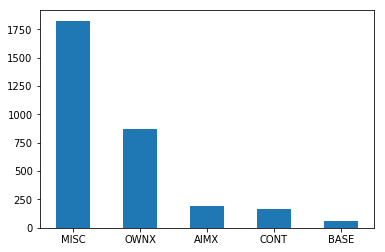

In [7]:
train['Label'].value_counts().plot(kind="bar", rot=0)

------

### LSTM

In [8]:
# Use the Keras tokenizer
num_words = 2000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train['Text'].values)

In [9]:
# Pad the data 
X = tokenizer.texts_to_sequences(train['Text'].values)
X = pad_sequences(X, maxlen=2000)

In [10]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')

model = Sequential()

model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))

model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))

model.add(Dense(5,activation='softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['categorical_crossentropy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 985       
Total params: 511,785
Trainable params: 511,785
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
Y = pd.get_dummies(train['Label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify=Y)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2493, 2000) (2493, 5)
(624, 2000) (624, 5)


In [ ]:
batch_size = 16
model.fit(X_train,
          Y_train, 
          epochs=32, 
          batch_size=batch_size,
          validation_split=0.2,
          callbacks=[ckpt_callback])

Train on 1994 samples, validate on 499 samples
Epoch 1/32
1994/1994 [==============================] - 724s - loss: 1.0572 - categorical_crossentropy: 1.0572 - val_loss: 0.7532 - val_categorical_crossentropy: 0.7532
Epoch 2/32
 176/1994 [=>............................] - ETA: 621s - loss: 0.5891 - categorical_crossentropy: 0.5891

In [28]:
model = load_model('keras_model')

In [29]:
probas = model.predict(X_test)

Log loss: 0.5629543447405292
Accuracy: 0.8413461538461539


/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


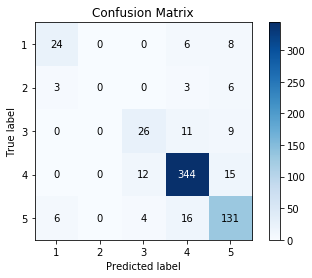

In [30]:
pred_indices = np.argmax(probas, axis=1)
classes = np.array(range(1, 10))
preds = classes[pred_indices]
print('Log loss: {}'.format(log_loss(classes[np.argmax(Y_test, axis=1)], probas)))
print('Accuracy: {}'.format(accuracy_score(classes[np.argmax(Y_test, axis=1)], preds)))
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis=1)], preds)

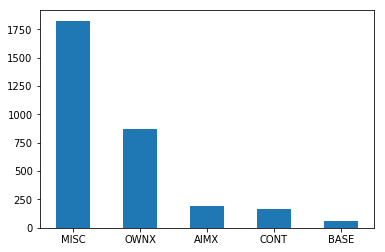

In [31]:
train['Label'].value_counts().plot(kind="bar", rot=0)